# Machine Learning for Core Engineering Disciplines

**Instructor**:
Prof. Ananth Govind Rajan  
Department of Chemical Engineering  
Indian Institute of Science, Bengaluru  
Email: ananthgr@iisc.ac.in  
Website: https://agrgroup.org

**Teaching Assistants**:
Dr. Manas Sharma, Shivam Chaturvedi, Manasi Lavhekar, Amar Krishna Gopinath 

## 4. Supervised machine learning with Python

This tutorial demonstrates various **supervised learning techniques**, focusing on tree-based methods, support vector machines, and Gaussian process regression, using Python. We will cover both **classification and regression models**.

### Topics include:
- **Decision trees** for interpretable modeling  
- **Random forests** for ensemble learning  
- **XGBoost and LightGBM** for high-performance gradient boosting  
- **Feature importance via SHapley Additive exPlanations (SHAP)** to explain model predictions  
- **Support vector machines (SVM)** for classification tasks  
- **Gaussian process regression (GPR)** for probabilistic regression  

### Decision trees in supervised learning (materials informatics)

This tutorial explores how decision tree-based models can be applied to materials science classification tasks. We focus on predicting **whether a material is metallic or not** using the **Matbench `is_metal`** dataset. Matbench is "an automated leaderboard for benchmarking state of the art ML algorithms predicting a diverse range of solid materials' properties".

We'll cover:

- **Basic decision trees** using scikit-learn  
- **Random forests** (bagging ensemble)  
- **Boosting algorithms** including scikit0-gradient boosting, XGBoost, and LightGBM  
- **SHAP values** for interpreting model predictions and feature importance  

The features are derived from the chemical composition of materials using **MAGPIE (Materials AGnostic Platform for Informatics and Exploration) descriptors**, enabling us to train interpretable models in a real-world materials informatics setting.


**Prerequisites**
Install necessary packages:

In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn shap xgboost lightgbm catboost matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 81.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 25.9 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexpar

#### Data loading and exploration

The **Matbench `is_metal`** dataset contains 4,900+ materials with their chemical compositions and a binary label indicating whether the material is metallic (`True`) or nonmetallic (`False`).

- **Features:** Computed using MAGPIE descriptors derived from the material’s composition (e.g., mean atomic number, electronegativity, atomic radius, etc.)
- **Target:** A binary classification label, `is_metal`
- **Use case:** Predict whether a material is a metal based on its elemental composition

**Data source:** [Matbench `is_metal` Leaderboard](https://matbench.materialsproject.org/Leaderboards%20Per-Task/matbench_v0.1_matbench_expt_is_metal/)


In [3]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings


from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty


import pandas as pd
from pymatgen.core.composition import Composition


# Load your dataset
df = load_dataset("matbench_expt_is_metal")

# Convert composition strings to Composition objects
df["composition_obj"] = df["composition"].apply(Composition)

# Apply MAGPIE-style element features
ep_feat = ElementProperty.from_preset("magpie")
df = ep_feat.featurize_dataframe(df, "composition_obj", ignore_errors=True)

# Drop the composition object (optional)
df.drop(columns=["composition_obj"], inplace=True)

# Final features and label
X = df[ep_feat.feature_labels()]
X.columns = X.columns.str.replace("MagpieData ", "") ## Replacing the prefix MagpieData from feature name
y = df["is_metal"]
print(X.shape)
print(y.shape)

Fetching matbench_expt_is_metal.json.gz from https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz to /usr/local/lib/python3.11/dist-packages/matminer/datasets/matbench_expt_is_metal.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz in MB: 0.034816MB [00:00, 42.40MB/s]                 


ElementProperty:   0%|          | 0/4921 [00:00<?, ?it/s]

(4921, 132)
(4921,)


Let's visualize the relationships between key compositional features and the `is_metal` label using a pair plot:

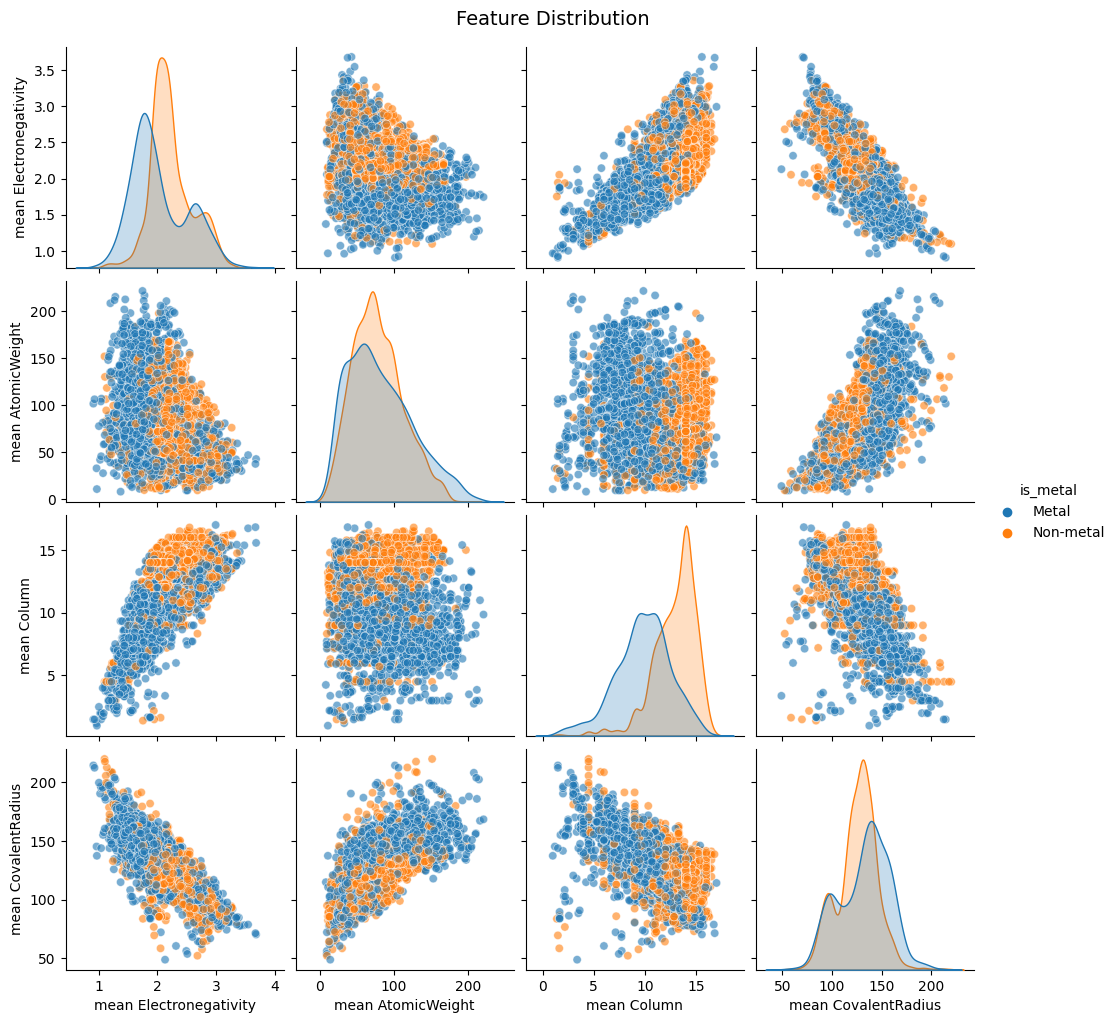

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected feature names
selected_features = [
    "mean Electronegativity",
    "mean AtomicWeight",
    "mean Column",
    "mean CovalentRadius"
]

# Create a DataFrame for plotting
df_plot = X[selected_features].copy()
df_plot['is_metal'] = y.map({True: "Metal", False: "Non-metal"})

# Pairplot visualization
sns.pairplot(df_plot,hue='is_metal', plot_kws={'alpha': 0.6})
plt.suptitle("Feature Distribution", y=1.02, fontsize=14)
plt.show()

As shown, metallic and non-metallic materials exhibit distinct patterns across several compositional features.

 ### Train-test split 

Before proceeding forward, we'll split the dataset into training and test sets to prepare for model building and evaluation:


In [5]:
from sklearn.model_selection import train_test_split
# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (3444, 132)
Test set shape: (1477, 132)


**Important**: Scaling is not necessary for tree-based models.

* Decision trees, random forests, gradient boosting, XGBoost, and LightGBM, all split based on feature thresholds, not on distances or dot products.
* They are invariant to monotonic transformations, including standardization or normalization.


But you do need scaling for:

* Support vector machines (SVM)
* K-nearest neighbors (KNN)
* Logistic regression
* Neural networks
* Gaussian process models

Thus, we will use scaling later for these models.

### Decision tree classifiers

### Introduction to decision trees

A **decision tree** is a supervised learning algorithm used for both **classification** and **regression** tasks. It works by recursively splitting the dataset into subsets based on feature values that result in the **highest information gain** (or lowest impurity).

At each step, the tree:
- Chooses the feature and threshold that best separate the data (using criteria like **Gini impurity** or **entropy**).
- Creates decision nodes and leaf nodes based on this split.
- Repeats this process recursively until a stopping condition is met (e.g., maximum depth, minimum samples per leaf).

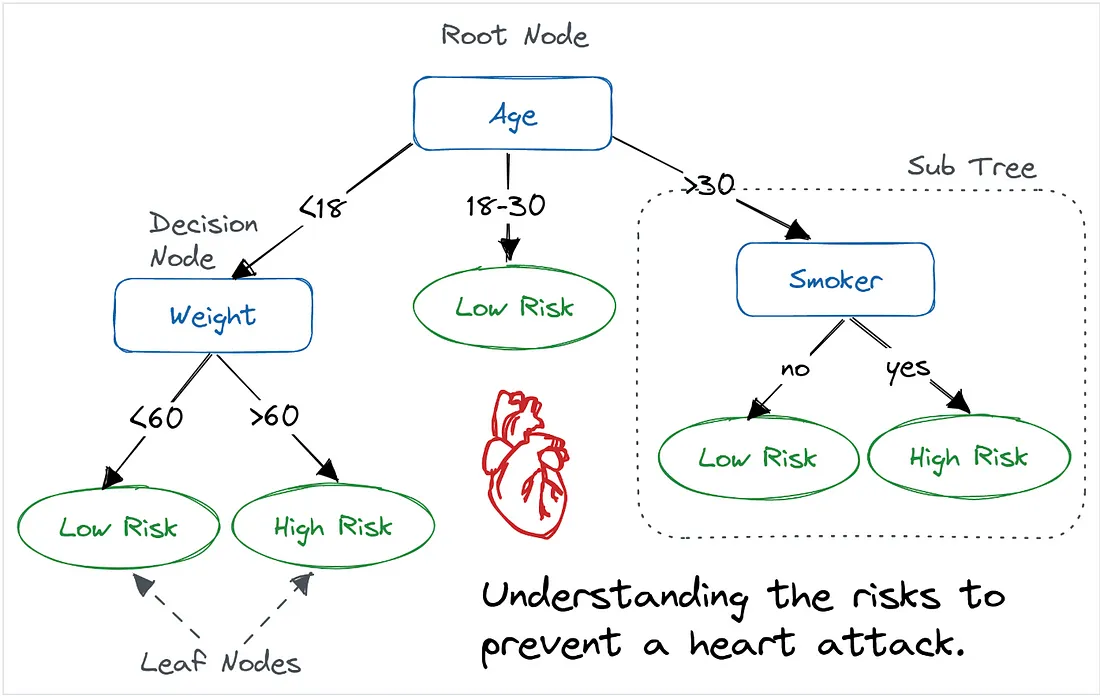

**Image Source:** [Decision Tree in Machine Learning: Simplifying Complex Decisions](https://medium.com/@glennlenormand/decision-tree-in-machine-learning-simplifying-complex-decisions-3657f9f2e48a)

### Key characteristics
- **Interpretable**: Easy to visualize and understand the logic behind predictions.
- **Nonlinear**: Captures complex decision boundaries.
- **Insensitive to feature scaling**: Unlike models like SVM or k-NN, decision trees don’t require feature standardization.
- **Prone to overfitting**: Without proper regularization (like limiting depth), trees can memorize training data.



Now let's train a **decision tree classifier** to predict whether a material is metallic or nonmetallic:

#### Training

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Train decision tree
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Accuracy score

We start by calculating the **accuracy score**, which is the proportion of correct predictions over all predictions. 
It's a simple and widely used metric for classification, especially when the classes are balanced.

Formula:  
**Accuracy = (True Positives + True Negatives) / Total Predictions**

In the dataset, accuracy gives us a quick measure of how well our decision tree is performing.

One can also compute the **balanced accuracy score**, defined as 

**Balanced accuracy= 0.5 x (True positive rate + True negative rate)**

Since we have carried out stratified sampling during train-test split, the balanced accuracy score will be close to the regular accuracy score.

In [7]:
accuracy = dt_clf.score(X_test, y_test)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.83


#### Classification report

Next, we generate a **classification report** that includes:

- **Precision**: The proportion of predicted positives that are actually correct.
- **Recall (Sensitivity/TPR)**: The proportion of actual positives that were correctly identified.
- **F1-score**: Harmonic mean of precision and recall. Balances both metrics, especially useful with class imbalance.
- **Support**: The number of true instances of each class in the dataset.

This helps us understand not just the overall accuracy but also how well the model performs **per class**.


In [8]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score

# Predictions
y_pred = dt_clf.predict(X_test)
y_proba = dt_clf.predict_proba(X_test)[:, 1]  # Probability of class '1' (Metal)

# Accuracy
dt_acc = dt_clf.score(X_test, y_test)
print(f"CatBoost Accuracy: {dt_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


CatBoost Accuracy: 0.83
F1 Score: 0.8139362490733877
ROC AUC: 0.8886850539811065

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.78      0.91      0.84       741
       Metal       0.90      0.75      0.81       736

    accuracy                           0.83      1477
   macro avg       0.84      0.83      0.83      1477
weighted avg       0.84      0.83      0.83      1477



Now, we'll cover the following bagging and boosting models on the **Matbench `is_metal`** dataset:

* Random forest (bagging)
* Gradient boosting (sklearn)
* XGBoost
* LightGBM

### Random forest classifier (bagging)

Random forest is an ensemble method that combines multiple decision trees using **bootstrap aggregation (bagging)**. 
Each tree is trained on a random subset of data and features, reducing variance and overfitting.
It is fast, easy to use, and robust to noisy data.

![DT vs RF](DTRF.png)

**Image Source:** [Decision Tree Vs Random Forest](https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/)



In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]  # Probability for class '1' (Metal)


# Accuracy
rf_acc = rf_clf.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


Random Forest Accuracy: 0.91
F1 Score: 0.91283459162663
ROC AUC: 0.9741517778560113

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.91      0.92      0.92       741
       Metal       0.92      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



### Gradient boosting classifier (boosting)

Gradient boosting builds trees sequentially, where each tree learns from the residual errors of the previous one.
Unlike bagging, it focuses on reducing bias and can achieve higher accuracy, but is more prone to overfitting if not tuned well.

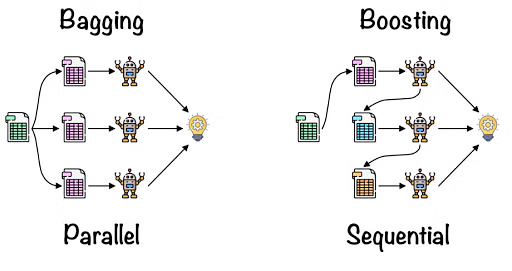

**Image Source:** [Random Forest Algorithm in Machine Learning](https://www.simplilearn.com/tutorials/machine-learning-tutorial/random-forest-algorithm)


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)

# Accuracy
gb_acc = gb_clf.score(X_test, y_test)


# Predictions
y_pred = gb_clf.predict(X_test)
y_proba = gb_clf.predict_proba(X_test)[:, 1]  # Probabilities for class '1' (metal)

print(f"Gradient Boosting Accuracy: {gb_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


Gradient Boosting Accuracy: 0.91
F1 Score: 0.906960716747071
ROC AUC: 0.9657429003109781

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.90      0.92      0.91       741
       Metal       0.92      0.89      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



### XGBoost classifier

XGBoost is an optimized and regularized version of gradient boosting.
It supports tree pruning, missing value handling, and is highly efficient with large datasets.


In [11]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Accuracy
xgb_acc = xgb_clf.score(X_test, y_test)

# Predictions
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilities for class '1' (Metal)

print(f"XGBoost Accuracy: {xgb_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


XGBoost Accuracy: 0.91
F1 Score: 0.9094650205761317
ROC AUC: 0.9694907733380274

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.90      0.92      0.91       741
       Metal       0.92      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



### LightGBM classifier

LightGBM is a fast, gradient boosting framework that uses histogram-based learning.
It is optimized for performance on large datasets and handles categorical features natively.
LightGBM uses **leaf-wise** tree growth, which can lead to faster convergence and better accuracy, but with a slight risk of overfitting.

In [12]:
from lightgbm import LGBMClassifier

# Train LightGBM
lgbm_clf = LGBMClassifier(random_state=42,verbose=-1)
lgbm_clf.fit(X_train, y_train)

# Accuracy
lgbm_acc = lgbm_clf.score(X_test, y_test)


# Predictions
y_pred = lgbm_clf.predict(X_test)
y_proba = lgbm_clf.predict_proba(X_test)[:, 1]  # Probability of class '1' (Metal)
print(f"LightGBM Accuracy: {lgbm_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification Report & Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


LightGBM Accuracy: 0.91
F1 Score: 0.9109730848861284
ROC AUC: 0.9715829079387432

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.90      0.93      0.91       741
       Metal       0.93      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



### CatBoost Classifier

CatBoost is a gradient boosting library developed by Yandex that handles **categorical variables natively** without preprocessing.
It is robust, fast to train, and often performs well with minimal tuning.
It uses **ordered boosting**, which helps reduce overfitting.

In [13]:
from catboost import CatBoostClassifier

# Train CatBoost
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)

# Accuracy
cat_acc = cat_clf.score(X_test, y_test)

# Predictions
y_pred = cat_clf.predict(X_test)
y_proba = cat_clf.predict_proba(X_test)[:, 1]  # Probability of class '1' (Metal)

print(f"CatBoost Accuracy: {cat_acc:.2f}")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification Report & Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))


CatBoost Accuracy: 0.91
F1 Score: 0.9078404401650619
ROC AUC: 0.9729232676172036

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.90      0.92      0.91       741
       Metal       0.92      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



Finally, let's compare the performance of different tree-based classifiers on the `is_metal` prediction task:

| Model          | Accuracy | F1 Score | ROC AUC |
|----------------|----------|----------|---------|
| Decision tree  | 0.83     | 0.8139     | 0.8886    |
| **Random forest**  | **0.91**     | **0.9128**     | **0.9741**    |
| XGBoost        | 0.91     | 0.9069     | 0.9657    |
| LightGBM       | 0.91     | 0.9109     | 0.9715    |
| CatBoost   | 0.91 | 0.9078 | 0.9729 |

####  Key takeaways

- **Random forest** is the **best overall performer** on this dataset. It offers:
  - The **highest F1 score**: `0.9128`, indicating the best balance between precision and recall.
  - The **highest ROC AUC**: `0.9741`, demonstrating strong ability to distinguish between metal and nonmetal classes.

- **LightGBM** and **XGBoost** perform nearly as well and are excellent alternatives.

- **Decision tree** shows **lower performance across all metrics**, making it **less ideal** for production use — unless model simplicity or interpretability is a top concern.

###  Feature importance with SHAP for the random forest model

Feature importance analysis helps us understand which input features contribute the most to a model's predictions. Traditional feature importance methods (like Gini importance in random forests) can be biased and less interpretable.

**SHAP (SHapley Additive exPlanations)** is a model-agnostic approach based on cooperative game theory. It assigns each feature an importance value for a particular prediction. SHAP values are:
- **Consistent**: If a model relies more on a feature, SHAP assigns it higher importance.
- **Interpretable**: It explains how each feature pushes the prediction higher or lower.

We'll use SHAP to visualize which chemical features most influence the model's classification of a compound as metal or nonmetal.

For more details on SHAP, see the official documentation: [SHAP GitHub Repository](https://github.com/shap/shap) and [SHAP documentation](https://shap.readthedocs.io/en/latest/).


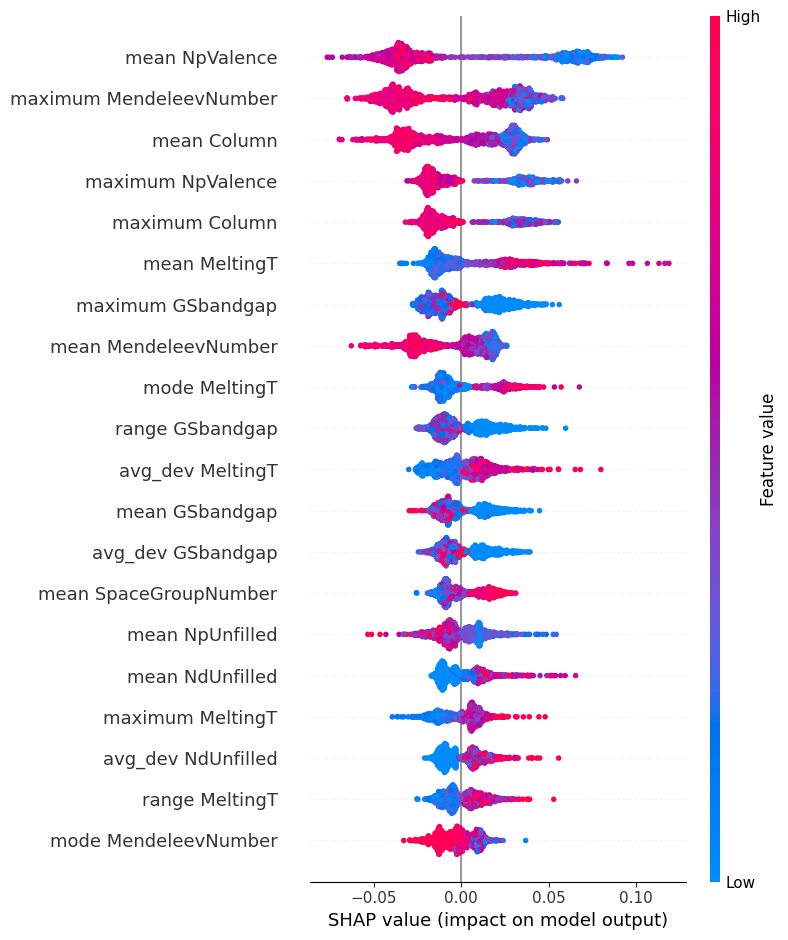

In [14]:
import shap

# Initialize SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf_clf)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Summary plot (for binary classification, class 1 is typically 'True' class)
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=20)


#### Hyperparameter tuning with grid search

Hyperparameter tuning helps find the best combination of these parameters to improve accuracy, generalization, and robustness. We'll use GridSearchCV, which systematically searches through combinations of parameters using cross-validation to find the best set.

Random forest models have several important hyperparameters (like the number of trees, depth of trees, etc.) that can significantly affect performance. By default, these parameters are not optimized, which can lead to suboptimal results.


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize model
rf_base = RandomForestClassifier(random_state=42)

# Set up GridSearch
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_rf = grid_search.best_estimator_

# Evaluate on test data
from sklearn.metrics import classification_report, roc_auc_score, f1_score

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
rf_acc = best_rf.score(X_test, y_test)

print(f"Random Forest accuracy after hyperparameter tuning: {rf_acc:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest accuracy after hyperparameter tuning: 0.92
F1 Score: 0.9191
ROC AUC: 0.9743

Classification Report:

              precision    recall  f1-score   support

       False       0.91      0.93      0.92       741
        True       0.93      0.91      0.92       736

    accuracy                           0.92      1477
   macro avg       0.92      0.92      0.92      1477
weighted avg       0.92      0.92      0.92      1477



###  Random forest performance: before vs after hyperparameter tuning

| Metric       | Before Tuning | After Tuning |
|--------------|----------------|---------------|
| F1 score     | 0.9128         | 0.9191        |
| ROC AUC      | 0.9741         | 0.9743        |

 **Takeaway**: Hyperparameter tuning slightly improved both F1 and ROC AUC scores, suggesting the model generalizes better and classifies metal/nonmetal samples with higher precision and recall.


---

###  Support vector machines (SVM)

So far, we've explored tree-based models like decision trees, random forests, and boosting algorithms. These models are powerful, but they follow a fundamentally different approach compared to kernel-based methods like SVM.

###  What is SVM?

Support vector machines (SVM) are supervised learning algorithms used for both classification and regression tasks. They work by finding the **optimal hyperplane** that best separates data points from different classes in a high-dimensional space. The goal is to **maximize the margin** between classes — the distance between the nearest data points (support vectors) and the decision boundary.

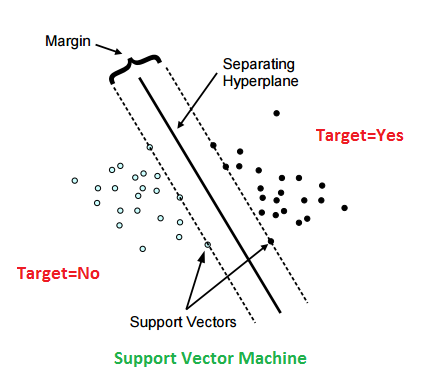

**Image Source:** [SVM Classifier](https://www.kaggle.com/code/prashant111/svm-classifier-tutorial)



###  Why use SVM?

- SVMs are especially effective in **high-dimensional spaces**.
- They perform well when there is a **clear margin of separation** between classes.
- Can handle **nonlinear classification** using the **kernel trick** (via, e.g., RBF, polynomial kernels).

---

Now that we've seen how tree-based models perform, let's explore how SVM fares on our classification task using the `matbench_expt_is_metal` dataset.


#### Without scaling SVM

Accuracy: 0.7813
F1 Score: 0.7825
ROC AUC Score: 0.8697
SVM Classification Report:



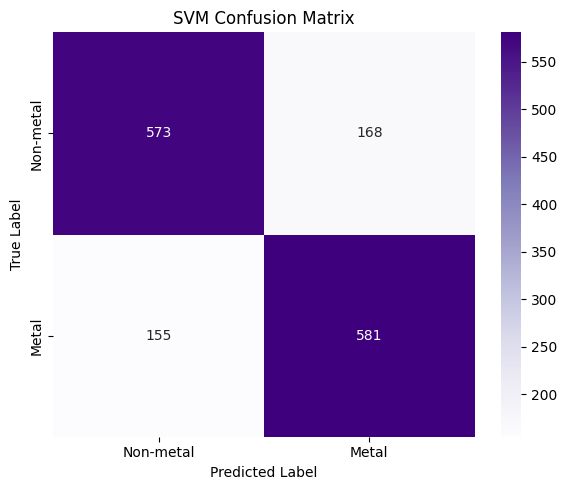

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train SVM
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Predictions
y_pred = svm_clf.predict(X_test)
y_proba = svm_clf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)

# Evaluation
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print("SVM Classification Report:\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Non-metal", "Metal"],
            yticklabels=["Non-metal", "Metal"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### With scaling SVM

Accuracy: 0.8842
F1 Score: 0.8833
ROC AUC Score: 0.9529
 SVM Classification Report:



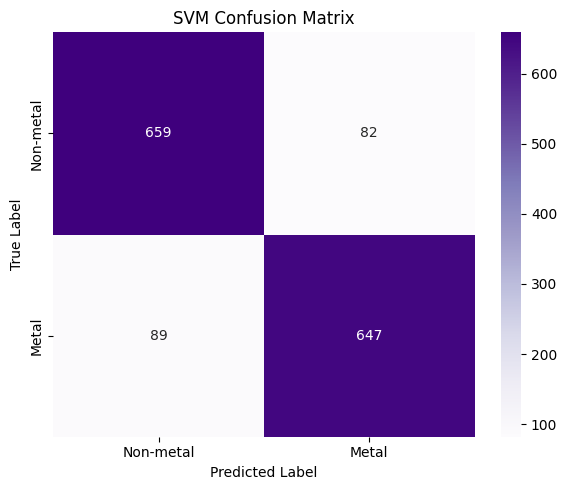

In [20]:
from sklearn.preprocessing import StandardScaler


#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train SVM with scaled features
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)

#  Predictions
y_pred = svm_clf.predict(X_test_scaled)
y_proba = svm_clf.predict_proba(X_test_scaled)[:, 1]
accuracy = accuracy_score(y_test, y_pred)


#  Evaluation
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print(" SVM Classification Report:\n")

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Non-metal", "Metal"],
            yticklabels=["Non-metal", "Metal"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

###  SVM performance: before vs after feature scaling

Feature scaling significantly improved the performance of the SVM model. After applying standard scaling, all metrics — accuracy, F1 score, and ROC AUC — showed substantial improvement.

| Metric       | Before Scaling | After Scaling |
|--------------|----------------|----------------|
| Accuracy     | 0.7813         | **0.8842**     |
| F1 Score     | 0.7825         | **0.8833**     |
| ROC AUC      | 0.8697         | **0.9529**     |

>  **Takeaway**: Support vector machines (SVMs) are sensitive to the scale of input features. Apply feature scaling (e.g., `StandardScaler`) before training an SVM.


To evaluate the classifier's ability to distinguish between metallic and nonmetallic materials, we can plot the receiver operating characteristic (ROC) curve.  
The ROC curve illustrates the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at various threshold settings.  
The area under the curve (AUC) provides a single metric summarizing the model's performance, where closer to 1 indicates better discrimination.


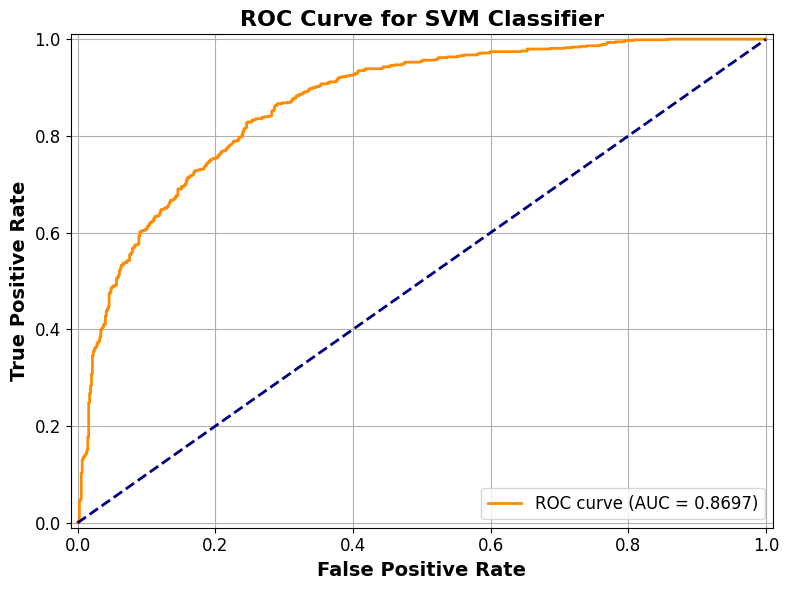

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR, and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Styling axes and text
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')
plt.title("ROC Curve for SVM Classifier", fontsize=16, fontweight='bold')
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc="lower right", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

####  Hyperparameter tuning for SVM using RandomizedSearchCV

#####  Key SVM hyperparameters:

- **`C`**: Regularization parameter. Controls trade-off between achieving a low training error and a low testing error (generalization).  
  - Smaller `C` values: Simpler decision surface, but higher training error.  
  - Larger `C` values: Tries to fit the training data better.

- **`kernel`**: Specifies the kernel type used in the algorithm. Common options:
  - `'linear'`: Suitable for linearly separable data.
  - `'rbf'`: Radial basis function, good for nonlinear boundaries.
  - `'poly'`: Polynomial kernel.
  
- **`gamma`**: Defines how far the influence of a single training example reaches.
  - High `gamma`: Overfitting risk (closer points only).
  - Low `gamma`: More generalized model.

---

######  What is `RandomizedSearchCV`?

`RandomizedSearchCV` is a powerful technique for hyperparameter optimization that:
- Samples a fixed number of parameter combinations from specified distributions.
- Is faster than `GridSearchCV` when the search space is large.
- Helps avoid overfitting by exploring a broader space with fewer evaluations.

Instead of exhaustively testing all combinations (as in Grid Search), it selects a **random subset** of combinations and evaluates them using cross-validation. This makes it ideal for expensive models like SVMs.

---

######  Why use It for SVM?

SVMs can be **sensitive to hyperparameters**, especially when using nonlinear kernels like `'rbf'`. Proper tuning of `C`, `gamma`, and `kernel` helps:
- Improve **model performance** on unseen data.
- Reduce **overfitting**.
- Find the **best decision boundary** for complex datasets.

>  **Takeaway**: Always scale your data and perform hyperparameter tuning when using SVMs for optimal performance.


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform
import numpy as np

# Define the parameter distribution
param_dist = {
    'C': uniform(0.1, 10),              # Regularization parameter
    'gamma': uniform(0.001, 1),         # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Different kernel types
}

# Initialize the SVM model
svm = SVC(probability=True, random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to try
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train_scaled, y_train)

# Best model
best_svm = random_search.best_estimator_
print("Best Parameters Found:")
print(random_search.best_params_)

# Predictions
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-metal", "Metal"]))
print(f"Accuracy     : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=sigmoid; total time=   3.0s
[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=sigmoid; total time=   3.1s
[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=sigmoid; total time=   3.2s
[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=sigmoid; total time=   3.6s
[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=poly; total time=   2.6s
[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=sigmoid; total time=   2.9s
[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=poly; total time=   3.0s
[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=poly; total time=   2.7s
[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=poly; total time=   2.7s
[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=poly; total time=   2.6s
[CV] END C=1.6599452033620266, gamma=0.059083612

###  SVM performance: before and after feature scaling + hyperparameter tuning

Feature scaling had a significant impact on SVM performance. After applying `StandardScaler`, the metrics—**accuracy**, **F1 score**, and **ROC AUC**—improved dramatically.

Further tuning the model using **RandomizedSearchCV** helped push performance even higher by finding optimal values for `C`, `gamma`, and `kernel`.

| Metric       | Before scaling | After scaling | After scaling and hyperparameter tuning |
|--------------|----------------|----------------|------------------------------|
| Accuracy     | 0.7813         | **0.8842**     | **0.9005**                   |
| F1 Score     | 0.7825         | **0.8833**     | **0.8998**                   |
| ROC AUC      | 0.8697         | **0.9529**     | **0.9574**                   |

>  **Takeaway**:  
> - **Feature scaling** is crucial for SVM models.  
> - **Hyperparameter tuning** further refines the decision boundary, leading to better classification performance.  
> - A combination of preprocessing and model optimization unlocks the full potential of SVM.


### Gaussian process regression (GPR): 

#### What is GPR?

**Gaussian process regression (GPR)** is a powerful and flexible nonparametric Bayesian approach to regression. Unlike traditional models that assume a fixed functional form (like linear regression), GPR defines a **distribution over possible functions** that fit the data. It predicts not only the output values but also provides **confidence intervals** (uncertainty estimates), making it especially useful for **scientific modeling** and **engineering applications**.

#### Why use GPR?

- **Uncertainty quantification**: Unlike many other regressors, GPR gives a **confidence interval** around each prediction.
- **Suitable for small datasets**: GPR often performs very well when the training data is limited — a common case in engineering applications.
- **Flexible modeling**: With appropriate kernels (e.g., RBF, Matern), GPR can model linear or highly nonlinear functions effectively.
- **Applications in core engineering disciplines**:
  - In **Mechanical Engineering**: Modeling stress-strain behavior, fatigue life prediction, and surrogate modeling in finite-element simulations.
  - In **Civil Engineering**: Predicting material degradation, structural reliability analysis, and geotechnical modeling.
  - In **Electrical Engineering**: Signal denoising, system identification, and performance prediction in analog circuits.
  - In **Aerospace Engineering**: Aerodynamic drag prediction, flight dynamics modeling, and uncertainty-aware design of experiments.
  - In **Chemical Engineering**: Reaction yield estimation, process optimization, and catalyst design under uncertainty.

GPR excels in engineering applications where:
- Experimental or simulation data is expensive or sparse.
- Uncertainty quantification is crucial for decision-making.
- Surrogate models are needed for optimization or control.
---

### When to use GPR?

- When **confidence in prediction** is just as important as the prediction itself.
- When you're working with **noisy or sparse data**.
- When the relationship between inputs and outputs may be **nonlinear or unknown**.

**Takeaway**: GPR is not just about predicting a number — it's about predicting a distribution. This makes it particularly valuable in scientific fields where understanding uncertainty is critical.

---

### Next Step: training GPR

In the following section, we will:
- Prepare data for regression (e.g., using a target like *formation energy*).
- Train a GPR model using `sklearn.gaussian_process`.
- Visualize the predictions and uncertainty bounds.

Let’s dive into GPR modeling!


##### Install the University of California, Irvine (UCI) machine learning repositories

In [23]:
!pip install ucimlrepo

### Dataset: concrete compressive strength

* **Source**: UCI machine learning repository  
* **Samples**: 1,030  
* **Type**: Regression  
* **Goal**: Predict the compressive strength of concrete based on its mix composition.

#### Features

* **Cement (kg/m³)**: Quantity of cement in the mix  
* **Blast furnace slag**: Amount of slag used  
* **Fly ash**: Fly ash content  
* **Water**: Water content in the mix  
* **Superplasticizer**: Chemical admixture for workability  
* **Coarse aggregate**: Large aggregate particles  
* **Fine aggregate**: Sand and smaller particles  
* **Age (days)**: Age of the concrete sample

#### Target

* **Concrete compressive strength (MPa)**:  
  The strength of the concrete after a given curing time.

  **Data source:** [Concrete Compressive Strength](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength)


In [40]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 

{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

In this example, we'll use GPR with a radial basis function (RBF) kernel, which assumes smooth, continuous relationships between features and the target.  
Before training, we'll standardize the input features to ensure better convergence and model stability.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score

#  Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Define and train GPR model
kernel = RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0)) 

# Train GPR
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Predict
y_train_pred, y_train_std = gpr.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test_scaled, return_std=True)

# Evaluate
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Results
print(" Gaussian Process Regression Results:")
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")
print()
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

 Gaussian Process Regression Results:
Train Mean Squared Error: 0.87
Train R² Score: 0.9969

Test Mean Squared Error: 948.51
Test R² Score: -2.6810


To improve the flexibility of the Gaussian process model, we can combine the RBF kernel with a constant kernel.  
The constant kernel helps model the overall signal magnitude, while the RBF captures smooth variations in the data.  

In [53]:
from sklearn.gaussian_process.kernels import ConstantKernel as C


#  Define and train GPR model
kernel = C(1.0, (0.1, 10.0)) * RBF() 
# Train GPR
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Predict
y_train_pred, y_train_std = gpr.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test_scaled, return_std=True)

# Evaluate
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Results
print(" Gaussian Process Regression Results:")
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")
print()
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

 Gaussian Process Regression Results:
Train Mean Squared Error: 0.87
Train R² Score: 0.9969

Test Mean Squared Error: 1345.19
Test R² Score: -4.2205


Moving forward, we extend the Gaussian process kernel by adding a **WhiteKernel** to model observation noise explicitly.  
We combine the **Constant** and **RBF kernels** to capture smooth trends, while the **WhiteKernel** accounts for random noise or measurement errors in the data.  
This composite kernel often leads to more robust predictions, especially when the dataset contains noisy observations.

In [54]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#  Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Define and train GPR model
kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel()
# Train GPR
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Predict
y_train_pred, y_train_std = gpr.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test_scaled, return_std=True)

# Evaluate
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Results
print(" Gaussian Process Regression Results:")
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")
print()
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

 Gaussian Process Regression Results:
Train Mean Squared Error: 15.27
Train R² Score: 0.9462

Test Mean Squared Error: 32.22
Test R² Score: 0.8749


### GPR kernel comparison: impact on model performance

Gaussian process regression (GPR) uses **kernel functions** to define similarity between data points. The choice of the kernel directly affects how well the model fits and generalizes.

#### Performance Comparison

| Kernel                     | Test MSE | Test R² Score |
|---------------------------|----------|----------------|
| RBF                       | 948.51    |-2.68       |
| Constant*RBF              | 1345.19  | -4.22        |
| Constant*RBF + WhiteKernel         | 32.22  | 0.8749         |

#### Observations

* **RBF + WhiteKernel** gave the best results, likely due to its flexibility and ability to handle noise.
* **RBF** alone or along with a scaled constant kernel was not able to perform well.

#### Key takeaways

* Different kernels significantly impact GPR performance.
* Adding a **WhiteKernel** helps model noise and improves generalization.
* It's important to **experiment with multiple kernels** and evaluate on a test set using appropriate metrics like **mean squared error (MSE)** and **R² score**.


###  Parity plot in regression

A **parity plot** is a diagnostic tool used in regression analysis to visualize how well the model’s predictions match the actual target values.

####  What it shows:
* The **x-axis** represents the **actual values** (ground truth).
* The **y-axis** represents the **predicted values** from the model.
* A **perfect model** would have all points lie exactly on the **45° diagonal line** (`y = x`), indicating perfect predictions.

####  Why it’s useful:
* Closeness to the diagonal indicates **high prediction quality**.
* Systematic deviations from the line may indicate:
  * **Bias** (underprediction or overprediction)
  * **Nonlinearity** or **model limitations**

####  Interpretation:
* Points **above** the line → model **overpredicts**
* Points **below** the line → model **underpredicts**
* The **spread around the line** reflects **model variance or data noise**


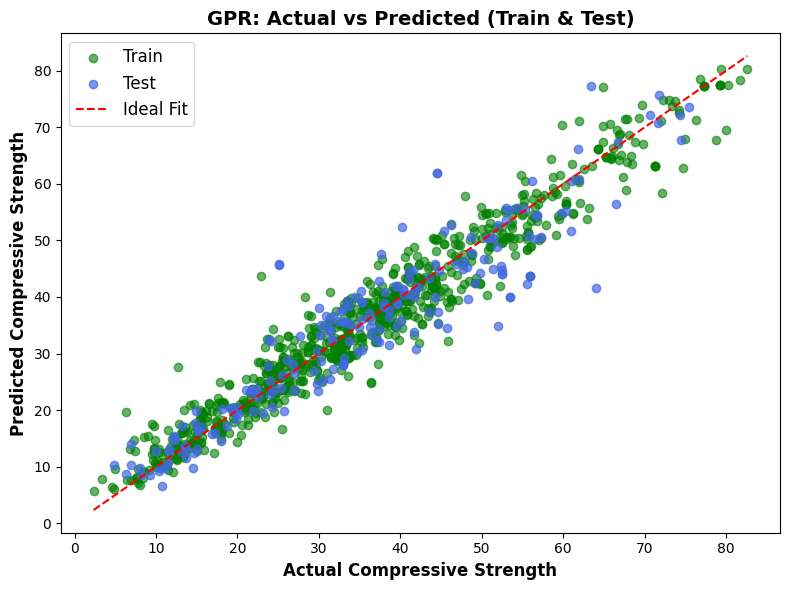

In [64]:
import matplotlib.pyplot as plt

# Flatten arrays
y_train_flat = y_train.values.ravel()
y_train_pred_flat = y_train_pred.ravel()

y_test_flat = y_test.values.ravel()
y_test_pred_flat = y_test_pred.ravel()

# Plot
plt.figure(figsize=(8, 6))

# Training points in green
plt.scatter(y_train_flat, y_train_pred_flat, color='green', label='Train', alpha=0.6)

# Testing points in blue
plt.scatter(y_test_flat, y_test_pred_flat, color='royalblue', label='Test', alpha=0.7)

# Ideal fit line
min_val = min(y_test_flat.min(), y_train_flat.min())
max_val = max(y_test_flat.max(), y_train_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], '--r', label='Ideal Fit')

# Labels and legend
plt.xlabel("Actual Compressive Strength", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Compressive Strength", fontsize=12, fontweight='bold')
plt.title("GPR: Actual vs Predicted (Train & Test)", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###  Residual plot in regression

A **residual plot** is a diagnostic tool used to evaluate the quality of a regression model by analyzing the **errors** (residuals) between predicted and actual values.

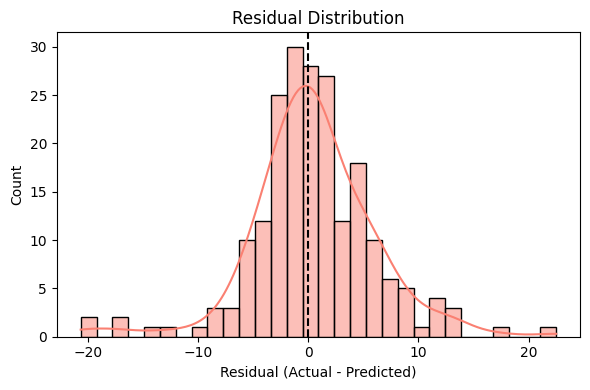

In [65]:
# Residual Plot
residuals = y_test.values.ravel() - y_test_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True, color='salmon')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

###  Uncertainty band in Gaussian process regression

An **uncertainty band** is a visual representation of the model's confidence in its predictions. It is especially useful when using **Gaussian process regression (GPR)**, which naturally provides both **mean predictions** and **standard deviations**.

####  What it shows:
* The **predicted values** are shown as a line.
* The **shaded area** around the prediction line represents the **confidence interval**, usually set at **95%**.
* Typically computed as:  
  `Prediction ± 1.96 × standard deviation`

####  Why it's useful:
* Quantifies the **model's uncertainty** across different predictions.
* Wider bands indicate **higher uncertainty**, while narrower bands imply **more confident predictions**.
* Helps assess **model reliability** and **data sufficiency** in different regions.

#### Interpretation:
* If actual values fall **within the band**, the model is performing reliably.
* **Consistently wide bands** may signal data sparsity or noise.
* **Sudden spikes** in uncertainty may suggest regions where the model lacks training examples.



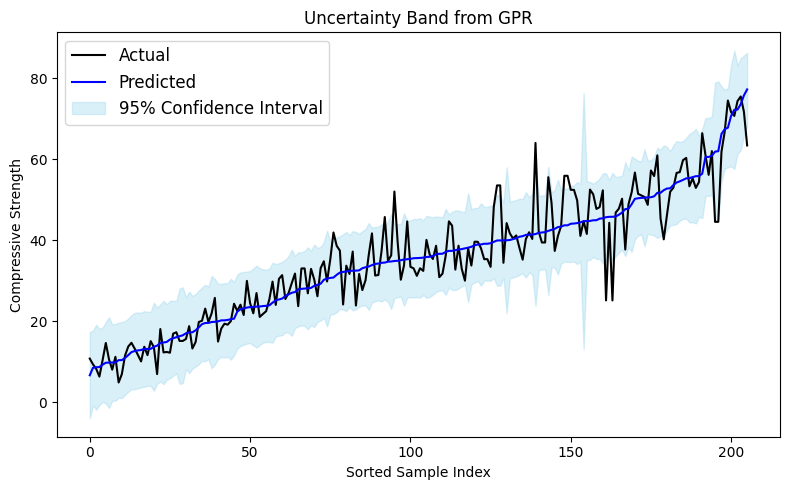

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test to 1D array
y_test_array = y_test.values.ravel()

# Sort indices based on predicted values
sorted_idx = np.argsort(y_test_pred)

# Plot actual vs predicted with confidence intervals
plt.figure(figsize=(8, 5))
plt.plot(y_test_array[sorted_idx], label="Actual", color="black")
plt.plot(y_test_pred[sorted_idx], label="Predicted", color="blue")
plt.fill_between(
    np.arange(len(y_test_pred)),
    y_test_pred[sorted_idx] - 1.96 * y_test_std[sorted_idx],
    y_test_pred[sorted_idx] + 1.96 * y_test_std[sorted_idx],
    alpha=0.3,
    label="95% Confidence Interval",
    color="skyblue"
)

plt.title("Uncertainty Band from GPR")
plt.xlabel("Sorted Sample Index")
plt.ylabel("Compressive Strength")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


To interpret the trained Gaussian process model, we use **permutation importance**, which measures how much each feature contributes to the prediction by randomly shuffling feature values and observing the impact on performance.

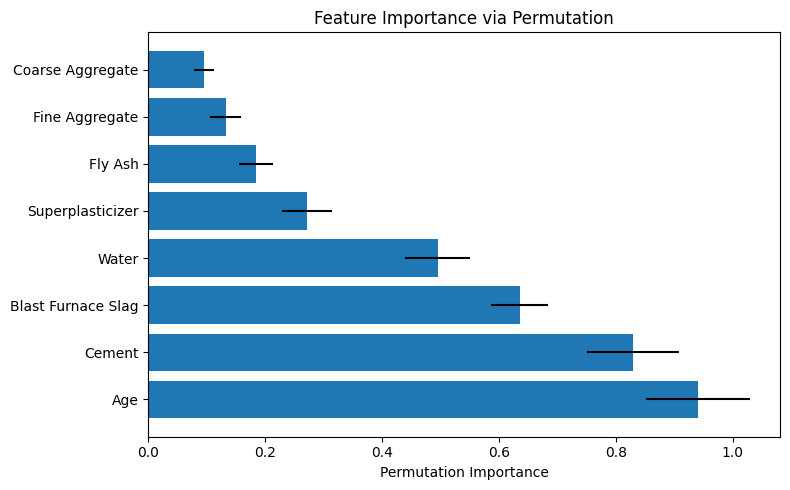

In [92]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve


# Permutation Importance
perm = permutation_importance(gpr, X_test_scaled, y_test.values.ravel(), n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()[::-1]

plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx], xerr=perm.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.tight_layout()
plt.show()
